# Code for launching all simulations
If no simulation result is present, this might take a while. 

In [2]:
from pylab import *
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
%matplotlib inline
import time

def loadtxt_faster(file):
    y=array(pd.read_csv(file,sep=' '))
    return(y[:,:-1])


In [9]:
! g++ -W -Wall -O3 two_choice_simulate.cc -o simulator
def launch_simus(dry_run=False):
    # dry_run=True does not do the computation but only indicate what remains to be computed
    simus = dict([]);
    total_simus = dict([]);
    for rhoInt in [40]: #[50,60,70,80,90,95,99]:
        for N in [10]: #[3,10,20,30,40,50,100,200,300,400,500,1000]:
            total_simus[(rhoInt,N)] = max(100,N*N/100);
    total_simus[(90,50)] = 10000; # useful to have enough data for Table~2 
        
    expected_time = 0;    
    for key in total_simus:
        fileName='results/exp_{0}_{1}'.format(key[0],key[1]);
        x = ! if [ -f $fileName ]; then wc -l $fileName | sed 's/ *\(.*\) res.*/\1/'; else echo 0; fi
        simus[key] = int(x[0])
        expected_time += max(0,total_simus[key]-simus[key])*.2; # It takes approximately .2 seconds to obtain one sample
    print('Expected time: approx {0}min (on a 2013 macbook, based on 20sec per 100 values)\n'.format(int(expected_time/60)))
    
    some_simulations_remain = True
    while some_simulations_remain:
        some_simulations_remain = False
        for (key,v) in total_simus.items():
            if simus[key] < v : 
                some_simulations_remain = True
                (rhoInt,N)=key
                fileName='results/exp_{0}_{1}'.format(rhoInt,key[1]);
                print("we launch 100 simulations for N={0} and rho={1} ({2} already done out of {3})".format(
                        N,.01*rhoInt,simus[key],total_simus[key]),end=' - ')
                if (not dry_run):
                    ! ./simulator r0.$rhoInt N$N e100 >> $fileName
                #! echo $fileName
                simus[key] += 100
                expected_time -= 20
                print('Remaining ~{0}min'.format(int(expected_time/60)))

    if not dry_run:
        print('all simulations done')
launch_simus(dry_run=False)

Expected time: approx 0min (on a 2013 macbook, based on 20sec per 100 values)

all simulations done


# Figures of the papers (for the two-choice model)

In [10]:
# For loading all values = confidence intervals
def load_values(rho,myN):
    moyenne = zeros((len(myN),20))
    uncert = zeros((len(myN),20))
    for (i,N) in enumerate(myN):
        a = loadtxt_faster("results/exp_{0}_{1}".format(int(100*rho),N))
        for j in range(20):
            moyenne[i,j] = mean(a[:,j])
            uncert[i,j] = 2*sqrt(var(a[:,j]) / len(a[:,j]))
        #print(N,len(a[:,1]))
    return(moyenne,uncert)
def load_mean(rho,myN):
    moyenne = zeros(len(myN))
    uncert = zeros(len(myN))
    for (i,N) in enumerate(myN):
        a = loadtxt_faster("results/exp_{0}_{1}".format(int(100*rho),N))
        moyenne[i] = mean(sum(a,1))-1
        uncert[i] = 2*sqrt(var(sum(a,1)) / len(a[:,0]))
        #print(N,len(a[:,1]))
    return(moyenne,uncert)


In [11]:
# Table 1 of the paper
rho = 0.90;
myN = [10,50,100,300,1000]
moyenne,uncert = load_values(rho,myN)
m,u = load_mean(rho,myN)
print(m)
print(u)
mean_th = sum(array([rho**(2**i-1) for i in range(1,100)]))
y = (sum(moyenne,1))-1
yerr = sum(uncert,1)
for (i,N) in enumerate(myN):
    print('N={0}\t m^N={1:.3f} +/- {2:.3e}, Err={3:.3e}'.format(N,y[i],yerr[i],y[i]-mean_th));
print('N=inf\t m  ={0}'.format(mean_th))

def m_N2(N,rho):
    mean_th = sum(array([rho**(2**i-1) for i in range(1,100)]))
    second = rho*rho/(1-rho)/2;
    return(mean_th+second/N)
for (i,N) in enumerate(myN):
    print('N={0}\t m^N-m^inf-1/N*rho**2/(1-rho)={1:.3e} +/- {2:.3e}'.format(N,y[i]-m_N2(N,rho),yerr[i]));



[ 2.80404783  2.43438418  2.39312296  2.36618822  2.35671989]
[ 0.00391893  0.00022484  0.00031884  0.00034161  0.00018269]
N=10	 m^N=2.804 +/- 4.580e-03, Err=4.514e-01
N=50	 m^N=2.434 +/- 2.316e-04, Err=8.173e-02
N=100	 m^N=2.393 +/- 3.248e-04, Err=4.047e-02
N=300	 m^N=2.366 +/- 3.454e-04, Err=1.354e-02
N=1000	 m^N=2.357 +/- 1.842e-04, Err=4.068e-03
N=inf	 m  =2.352651639591488
N=10	 m^N-m^inf-1/N*rho**2/(1-rho)=4.640e-02 +/- 4.580e-03
N=50	 m^N-m^inf-1/N*rho**2/(1-rho)=7.325e-04 +/- 2.316e-04
N=100	 m^N-m^inf-1/N*rho**2/(1-rho)=-2.868e-05 +/- 3.248e-04
N=300	 m^N-m^inf-1/N*rho**2/(1-rho)=3.658e-05 +/- 3.454e-04
N=1000	 m^N-m^inf-1/N*rho**2/(1-rho)=1.825e-05 +/- 1.842e-04


0.9


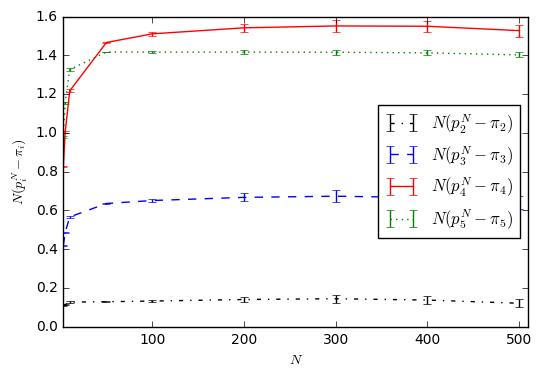

In [12]:
# Figure 4
rho=0.90;
myN = [3,5,10,50,100,200,300,400,500]
moyenne,uncert = load_values(rho,myN)

colors=['','','k','b','r','g','c','m'];
ls=['','','-.','--','-',':','-','-.'];
print(rho)
fig = figure();
fig.set_size_inches(6,4)
if rho==.8 or rho == 0.9:
    myI = [2, 3, 4, 5]
    #ylim([0,1.8])
else:
    myI = [3, 5 , 6,  7]
for i in myI:
    piI = rho**(2**i-1);
    errorbar(x=myN,y=myN*(moyenne[:,i]-piI),yerr=myN*uncert[:,i],ls=ls[i],color=colors[i])
legend(['$N(p_{0}^N-\pi_{0})$'.format(i) for i in myI],loc='best')
xlim([min(myN),max(myN)+10])
xlabel('$N$')
ylabel("$N(p_i^N-\pi_i)$")
fig.savefig('2choice_convergence_rho{0}.pdf'.format(int(100*rho)),bbox_inches='tight')

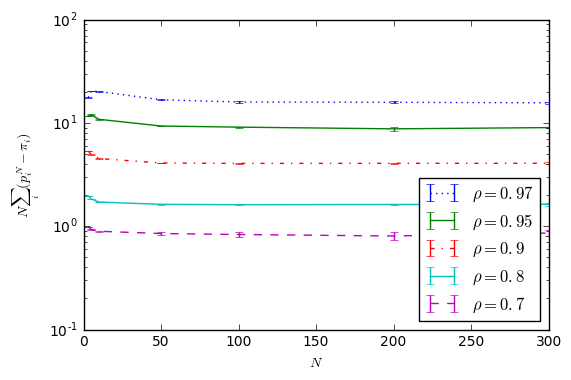

In [13]:
#Figure 5
fig = figure();
#gca().set_yscale("log")
ls=[':',':','-','-.','','-','','--','','']
plotRho = [.97,.95,.90,.80,.70]
myN = [3,5,10,50,100,200,300,1000]
myRho = array([0.50,0.60,0.70,0.75,0.80,0.85,0.90,0.95,0.97,0.99]);
c_rho = zeros((len(myRho),len(myN)));
c_rho_err = zeros((len(myRho),len(myN)));
for (i,rho) in enumerate(reversed(myRho)):
    avg,v_avg = load_mean(rho,myN)
    mean_th = sum(array([rho**(2**i-1) for i in range(1,100)]))
    y = myN*(avg-mean_th);
    yerr = myN*v_avg;
    for j in range(len(myN)):
        c_rho[i,j] = y[j];
        c_rho_err[i,j]=yerr[j];
    if rho in plotRho:
        errorbar(x=myN,y=y, yerr=yerr,ls=ls[i])
    xlim([min(myN),max(myN)+10])
lgd = ['$\\rho={0}$'.format(i) for i in plotRho]
legend(tuple(lgd),loc='best')
xlim([0,300])
xlabel('$N$')
ylabel('$N\sum_i(p^N_i - \pi_i)$')
fig.savefig('2choice_convergence_mean_noLog.pdf',bbox_inches='tight')
gca().set_yscale("log")
fig.savefig('2choice_convergence_mean.pdf',bbox_inches='tight')
#

0.99:	47.89196260421935
0.97:	15.69921112807382
0.95:	8.633428042261304
0.9:	4.068254431489837
0.85:	2.31930607889419
0.8:	1.6246592662989556
0.75:	1.1488185022452413
0.7:	0.8551803985441531
0.6:	0.5080390004310598
0.5:	0.30120399331501346


[None, None, None, None, None, None, None, None, None, None]

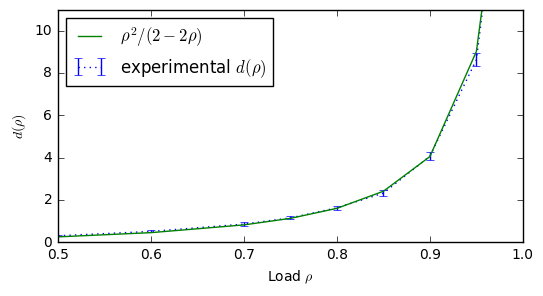

In [14]:
# Figure 6a
myRho_rev = array([rho for rho in reversed(myRho)])
fig = figure(1);
fig.set_size_inches(6,3)
plt1=errorbar(x=myRho_rev,y=c_rho[:,-1],yerr=c_rho_err[:,-1],ls=':')
#plt3=plot(myRho,0.5/(1-myRho),'--')
plt2=plot(myRho,0.5*myRho**(2)/(1-myRho),'-')
ylim([0,11])
xlim([0.5,1])
#legend(('$1/(2-2\\rho)$','$\\rho^2/(2-2\\rho)$','experimental $d({\\rho})$'),loc='best')
legend(('$\\rho^2/(2-2\\rho)$','experimental $d({\\rho})$'),loc='best')
xlabel("Load $\\rho$")
ylabel("$d(\\rho)$") #$1000(m^{1000}(\\rho)-m^\\infty(\\rho)) \\approx 
fig.savefig('C_rho.pdf',bbox_inches='tight')
[print('{0}:\t{1}'.format(myRho_rev[i],c_rho[i,-1])) for i in range(len(myRho))]
#plot(arange(0.7,.99,.001), 0.5/(1-arange(0.7,.99,.001)))

curve= 1000


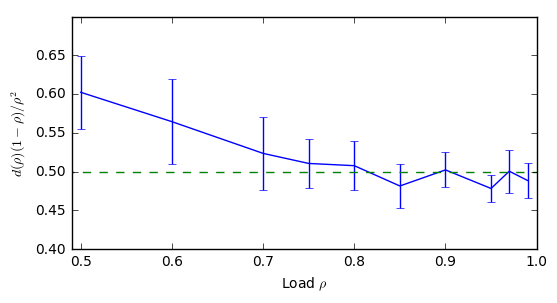

In [15]:
# Figure 6b
f = figure(1);
f.set_size_inches(6,3)
fit = (1-myRho_rev) / myRho_rev**(2)
for i in [-1]:
    errorbar(x=myRho_rev,y=c_rho[:,i]*fit,yerr=c_rho_err[:,i]*fit,ls='-')
    print('curve=',myN[i]);
plot([0,1],[.5,.5],'--')
#legend(('1','2','3'))
xlim([0.49,1])
ylim([0,1])
ylim([0.4,.7])
xlabel('Load $\\rho$')
ylabel('$d(\\rho)(1-\\rho)/\\rho^2$')
f.savefig('C_rho_conv.pdf',bbox_inches='tight')

ignore='''
[print('{0:.2f}'.format(myRho_rev[i]),end=' & ') for i in reversed(range(len(myRho_rev)))]; print()
for i in reversed(range(len(myRho_rev))):
    print('{0:.2f}\\pm{1:.2f}'.format(c_rho[i,-1],c_rho_err[i,-1]),end=' & ')
print()
for i in reversed(range(len(myRho_rev))):
    rho = myRho_rev[i];
    print('{0:.2f}'.format(rho*rho/(2-2*rho)),end=' & ')
'''

In [16]:
rho = 0.90;
#myN = array([3,5,10,20,30,40,50,100,200,300,400,500,700])
#moyenne,uncert = load_values(rho,myN)
#mean_th = sum(array([rho**(2**i-1) for i in range(100)]))
#y = sum(moyenne,1)
#yerr = sum(uncert,1)
#y2,yerr2 = load_mean(rho,myN)

def m_N2(N,rho):
    mean_th = sum(array([rho**(2**i-1) for i in range(1,100)]))
    second = rho*rho/(1-rho)/2;
    return(mean_th+second/N)

In [17]:
# Table 2 of the paper 
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

myN = [10,20,30,50]
moyenne,uncert = load_values(rho,myN)
y,yerr = load_mean(rho,myN)

print('$N$');
for N in myN:   print('&${0:4d}$ '.format(N),end=' ')
print('\\\\\\hline $m^N$ ($\\pm5.10^{-4}$)')
for (i,N) in enumerate(myN): print('&${0:.3f}$'.format(y[i],),end=' ')
print('\\\\\\hline $m^\\infty+d(\\rho)/N$ ')
for N in myN: print('&${0:.3f}$'.format(m_N2(N,rho)),end=' ')
print('\\\\\\hline Error&')
for N in myN: print(latex_float(abs(m_N2(N,rho)-y[i])),end='&')

#for (i,N) in enumerate(myN): print (yerr[i])
print('\n',mean_th)

$N$
&$  10$  &$  20$  &$  30$  &$  50$  \\\hline $m^N$ ($\pm5.10^{-4}$)
&$2.804$ &$2.567$ &$2.491$ &$2.434$ \\\hline $m^\infty+d(\rho)/N$ 
&$2.758$ &$2.555$ &$2.488$ &$2.434$ \\\hline Error&
$3.23 \times 10^{-1}$&$1.21 \times 10^{-1}$&$5.33 \times 10^{-2}$&$7.33 \times 10^{-4}$&
 0.632843018044


## Indication that the remaining error is in O(N^{-2})
Note: for $N\ge100$, we would need more simulations. 

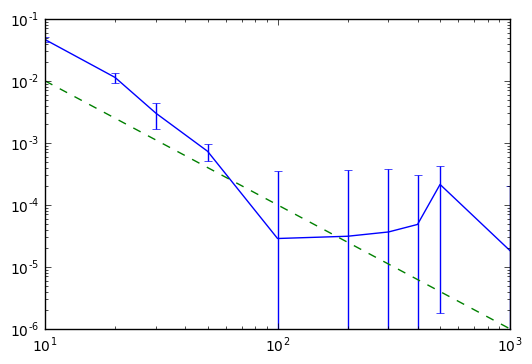

In [18]:

myN = [10,20,30,50,100,200,300,400,500,1000]
y,yerr = load_mean(rho,myN)
z = [abs(m_N2(N,rho)-y[i]) for i,N in enumerate(myN)]
errorbar(myN,y=z,yerr=yerr)
#errorbar(myN,y=z2,yerr=yerr2)
gca().set_xscale("log")
gca().set_yscale("log")
plot(myN,1/array(myN)**2,'--')

# Other figures

In [19]:
#1-2**arange(0,10)
myRho = [rho for rho in (1-2**(-1.-arange(0,200)))]
[(rho,sum(array([rho**(2**i-1) for i in range(200)])/log(1/(1-rho)))*log(2)) for rho in myRho];


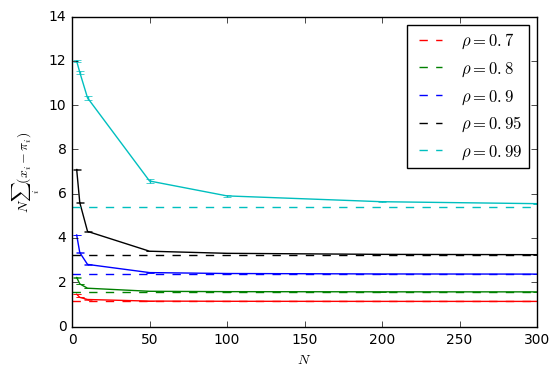

In [20]:
colors=['r','g','b','k','c']
fig = figure();
#gca().set_yscale("log")
plotRho = [.70,.80,.90,.95,.99]
myN = [3,5,10,50,100,200,300,500,1000]
for (i,rho) in enumerate(plotRho):
    moyenne,uncert = load_values(rho,myN)
    mean_th = sum(array([rho**(2**i-1) for i in range(1,100)]))
    y = (sum(moyenne,1))-1
    yerr = sum(uncert,1)
    #plot(myN,myN*x)
    if rho in plotRho:
        errorbar(x=myN,y=y, yerr=yerr,color='{0}'.format(colors[i]))
        plot([0,max(myN)],[mean_th,mean_th],'{0}--'.format(colors[i]))
    xlim([min(myN),max(myN)+10])
    #ylim([0,.01])
lgd = ['$\\rho={0}$'.format(i) for i in plotRho]
legend(tuple(lgd),loc='best')
xlim([0,300])
xlabel('$N$')
ylabel('$N\sum_i(x_i - \pi_i)$')
fig.savefig('2choice_convergence_mean_notRescaled.pdf',bbox_inches='tight')


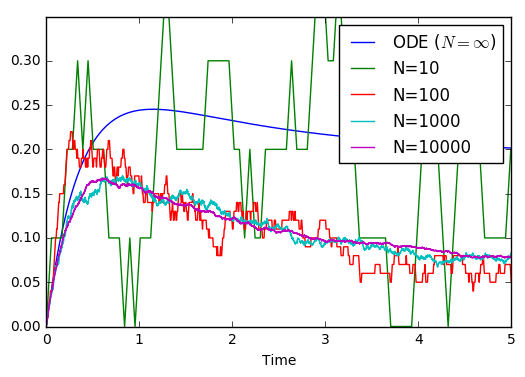

In [32]:
for N in [10,100,1000,10000]:
    fileName = "traj_{0}".format(N)
    ! if [ ! -e $fileName ]; then ./simulator r0.8 t N$N > $fileName; fi;
# ODE vs. mean-field (one trajectory)
def ode_2_choice(rho,T):
    h = 0.01;
    myT = arange(0,T,.01)
    x = array( [[0. for i in range(20)] for t in myT])
    x[0,0] = 1;
    x[0,1] = 1;
    x[0,2] = 1;
    for i in range(len(myT)-1):
        dx = [0 for i in range(20)];
        for j in range(1,19):
            dx[j] = x[i,j+1]-x[i,j] + rho*(x[i,j-1]**2-x[i,j]**2);
        dx[19] = -x[i,19] + rho*(x[i,18]**2-x[i,19]**2);
        for j in range(20):
            x[i+1,j] = x[i,j] + h*dx[j];
    return(myT,x)
i=3
rho=0.8
fig = figure();
myT,x = ode_2_choice(rho,10)
plot(myT,x[:,i]-x[:,i+1])
xlim([0,5])
ylim([0,0.35])
xlabel('Time')
legend(('ODE ($N=\infty$)','N=10','N=100','N=1000','N=10000'),loc='best')
fig.savefig('traj_rho80_N0.pdf',bbox_inches='tight')
for N in [10,100,1000,10000]:
    a = loadtxt('traj_{0}'.format(N))
    plot(linspace(0,10,10*N)/(1+rho),a[:,i]-a[:,i+1])
    legend(('ODE ($N=\infty$)','N=10','N=100','N=1000','N=10000'),loc='best')
    fig.savefig('traj_rho80_N{0}.pdf'.format(N),bbox_inches='tight')


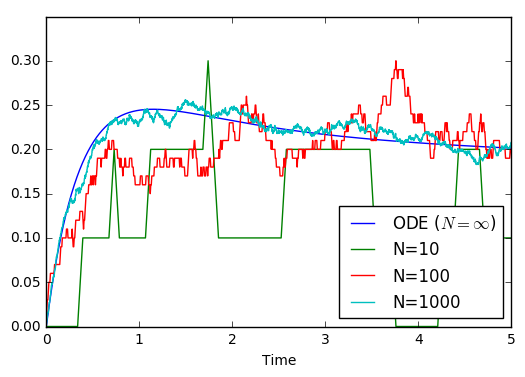

In [81]:
i=3
rho=0.8
fig = figure();
myT,x = ode_2_choice(rho,10)
plot(myT,x[:,i]-x[:,i+1])
xlim([0,5])
ylim([0,0.35])
xlabel('Time')
legend(('ODE ($N=\infty$)','N=10','N=100','N=1000','N=10000'),loc='best')
for N in [10,100,1000]:
    a = loadtxt('traj_{0}'.format(N))
    plot(linspace(0,10,10*N)/(1+rho),a[:,i]-a[:,i+1])
    legend(('ODE ($N=\infty$)','N=10','N=100','N=1000'),loc='best')
fig.savefig('traj_rho80_onlyN{0}.pdf'.format(N),bbox_inches='tight')


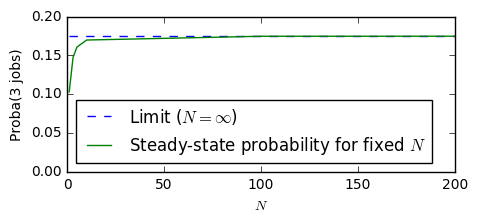

In [22]:
# 
fig = figure();
fig.set_size_inches(5,2)
myN = array([1,3,5,10,100,200]);
piI = rho**(2**i-1)-rho**(2**(i+1)-1);
values = zeros(len(myN))
moyenne,uncert = load_values(rho,myN)
for (j,N) in enumerate(myN):
    values[j] = moyenne[j,i]-moyenne[j,i+1];
plot(myN,myN*0+piI,'--')
plot(myN,values)
xlabel('$N$')
ylabel('Proba(3 jobs)')
legend(('Limit ($N=\infty$)','Steady-state probability for fixed $N$'),loc='best')
#ylabel("$N(p_i^N-\pi_i)$")
ylim(0,0.2)
fig.savefig('proba_convergence{0}.pdf'.format(int(100*rho)),bbox_inches='tight')

In [72]:
# Average over N simulations
%system mkdir traj/
%system for i in `seq 1 20000`; do file=traj/sample_${i}; if [ ! -f $file ]; then ./simulator t N10 > $file; fi; done

[]

In [73]:
import os.path
if os.path.isfile('traj/avgN10_20000'): 
    a = loadtxt('traj/avgN10_20000')
else:
    a = loadtxt_faster('traj/sample_1')/20000
    for i in range(2,20000):
        a += loadtxt_faster('traj/sample_{0}'.format(i))/20000
    savetxt('traj/avgN10_20000',a)


100 99 99


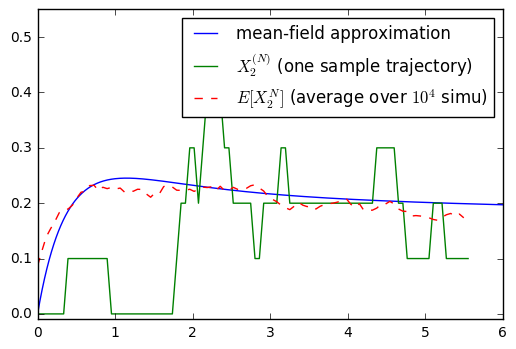

In [79]:
N=10
i=3
rho=0.8
fig = figure();
myT,x = ode_2_choice(rho,10)
plot(myT,x[:,i]-x[:,i+1])
traj = loadtxt('traj/sample_1')
print(len(traj[:,i]),len(linspace(0,10,10*N)[:-1]),len(a[:,i]))
plot(linspace(0,10,10*N)/(1+rho),traj[:,i]-traj[:,i+1])
plot(linspace(0,10,10*N)[:-1]/(1+rho),a[:,i]-a[:,i+1],'--')
ylim([-.01,.55])
xlim([0,6])
legend(('mean-field approximation','$X^{(N)}_2$ (one sample trajectory)', '$E[X^{N}_2]$ (average over $10^4$ simu)'))
fig.savefig('mean_field_avg_traj.pdf',bbox_inches='tight')

# Comparison with "power of (a little of) centralization"
## Remark 

To be more, we would need more simulations. At least, we observe that the marginal law of one object does not converge in $O(1/N)$ but rather in $O(1/\sqrt{N})$ for $i$ close to $i^*$. 

## Parameter
we set $q=0.05$

In [23]:
rho=0.80;
K=30;
myN = [10,20,50,100,200,500,1000]
def load_values_cen(rho,myN):
    moyenne = zeros((len(myN),K))
    uncert = zeros((len(myN),K))
    for (i,N) in enumerate(myN):
        #print(N)
        a = loadtxt("results/exp_q05_{0}_{1}".format(int(100*rho),N))
        for j in range(K):
            moyenne[i,j] = mean(a[:,j])
            uncert[i,j] = 2*sqrt(var(a[:,j]) / len(a[:,j]))
    return(moyenne,uncert)
moyenne,uncert = load_values_cen(rho,myN)

[1.0000000000000004, 0.7894736842105268, 0.6121883656509699, 0.46289546581134305, 0.3371751291042889, 0.231305371877296, 0.14215189210719664, 0.06707527756395504, 0.0038528653170147864, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[  1.00000000e+00   7.89418533e-01   6.12080780e-01   4.62768998e-01
   3.37072618e-01   2.31287517e-01   1.43093660e-01   7.21832812e-02
   1.97071063e-02  -1.45650062e-02  -3.39703062e-02  -4.35113500e-02
  -4.75563312e-02  -4.68892937e-02  -3.54115250e-02  -1.43585750e-02
  -4.75686875e-03  -5.35881250e-04  -1.10500000e-04   1.61250000e-06
   7.50000000e-07   3.43750000e-07   1.43750000e-07   5.62500000e-08
   3.12500000e-08   1.25000000e-08   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[[  1.00000000e+000   7.89439500e-001   6.12170875e-001   4.62885725e-001
    3.36753488e-001   2.29301100e-001   1.37467987e-001   6.12161375e-002
    1.96043750e-003  -4.01264125e-002  -6.72610625e-002  -8.32157250e-002
   -9.1535

(0, 200)

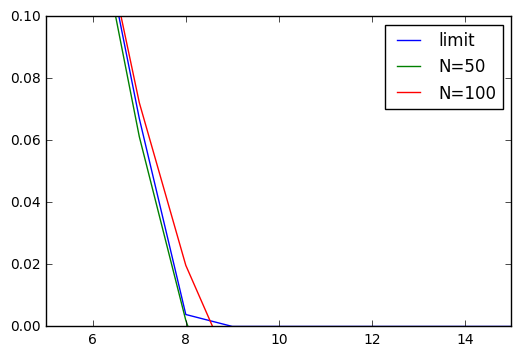

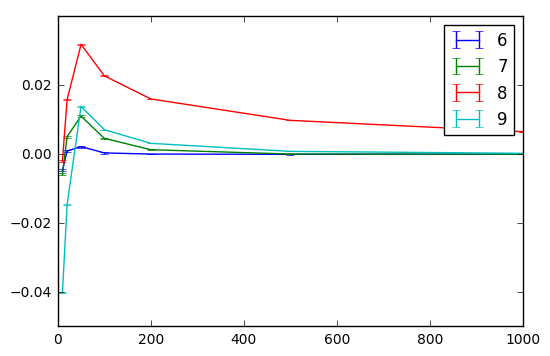

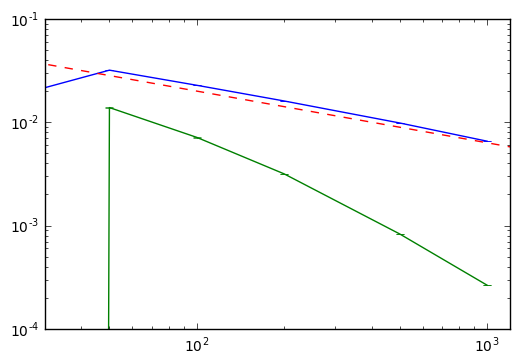

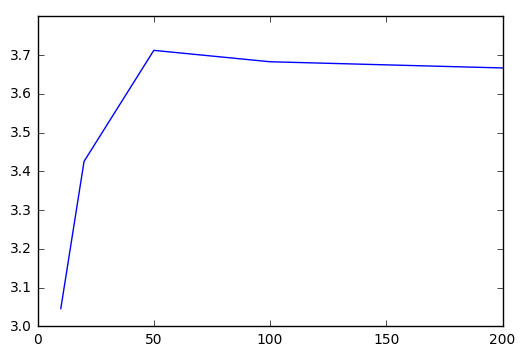

In [24]:
#THmean = 1-array([sum([(1-rho)*(rho/(1-q))**i for i in range(j)]) for j in range(20)])
q=0.05;
if rho==1-q:
    THmean = [max(0,1-q/(1-q)*i) for i in range(30)];
else:
    THmean = [max(0,(1-rho)/(1-(q+rho)) *(rho/(1-q))**i - q/(1-(q+rho))) for i in range(30)]
print(THmean)
print(moyenne[1,:])
figure()
plot(THmean)
plot(moyenne[0,:])
plot(moyenne[1,:])
legend(('limit','N=50','N=100'))
xlim([5,15])
ylim([0,.1])
figure()
miI = [6,7,8,9]
for i in miI:
    errorbar(myN,moyenne[:,i] - THmean[i], uncert[:,i])
legend(['{0}'.format(i) for i in miI])
moyenne[-1,:] - THmean[:]
figure();
errorbar(myN,moyenne[:,8] - THmean[8], uncert[:,8])
errorbar(myN,moyenne[:,9] - THmean[9], uncert[:,9])
gca().set_yscale("log")
gca().set_xscale("log")
plot([10,10000],0.2*array([10,10000])**(-0.5),'--')
xlim([30,1200])

figure()
plot(myN,sum(moyenne,1))
print(moyenne,1)
xlim([0,200])